# compile SDSS galaxy spectra
I will compile SDSS spectra from the DR16 (latest) SDSS data reduction

In [1]:
import os
import numpy as np 
import astropy.table as aTable
import astropy.io.fits as fits

In [2]:
import matplotlib.pyplot as plt

## read in SDSS DR16 specobj catalog

In [3]:
# specObj-dr16.fits can be downloaded from 
# https://data.sdss.org/sas/dr16/sdss/spectro/redux/specObj-dr16.fits
specobj = aTable.Table.read('/Users/chahah/data/arcoiris/specObj-dr16.fits')

In [4]:
specobj[:5]

SURVEY,INSTRUMENT,CHUNK,PROGRAMNAME,PLATERUN,PLATEQUALITY,PLATESN2,DEREDSN2,LAMBDA_EFF,BLUEFIBER,ZOFFSET,SNTURNOFF,NTURNOFF,SPECPRIMARY,SPECSDSS,SPECLEGACY,SPECSEGUE,SPECSEGUE1,SPECSEGUE2,SPECBOSS,BOSS_SPECOBJ_ID,SPECOBJID,FLUXOBJID,BESTOBJID,TARGETOBJID,PLATEID,NSPECOBS,FIRSTRELEASE,RUN2D,RUN1D,DESIGNID,CX,CY,CZ,XFOCAL,YFOCAL,SOURCETYPE,TARGETTYPE,THING_ID_TARGETING,THING_ID,PRIMTARGET,SECTARGET,LEGACY_TARGET1,LEGACY_TARGET2,SPECIAL_TARGET1,SPECIAL_TARGET2,SEGUE1_TARGET1,SEGUE1_TARGET2,SEGUE2_TARGET1,SEGUE2_TARGET2,MARVELS_TARGET1,MARVELS_TARGET2,BOSS_TARGET1,BOSS_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,EBOSS_TARGET_ID,ANCILLARY_TARGET1,ANCILLARY_TARGET2,SPECTROGRAPHID,PLATE,TILE,MJD,FIBERID,OBJID [5],PLUG_RA,PLUG_DEC,CLASS,SUBCLASS,Z,Z_ERR,RCHI2,DOF,RCHI2DIFF,TFILE,TCOLUMN [10],NPOLY,THETA [10],VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,WAVEMIN,WAVEMAX,WCOVERAGE,ZWARNING,SN_MEDIAN_ALL,SN_MEDIAN [5],CHI68P,FRACNSIGMA [10],FRACNSIGHI [10],FRACNSIGLO [10],SPECTROFLUX [5],SPECTROFLUX_IVAR [5],SPECTROSYNFLUX [5],SPECTROSYNFLUX_IVAR [5],SPECTROSKYFLUX [5],ANYANDMASK,ANYORMASK,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I,ELODIE_FILENAME,ELODIE_OBJECT,ELODIE_SPTYPE,ELODIE_BV,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,ELODIE_Z,ELODIE_Z_ERR,ELODIE_Z_MODELERR,ELODIE_RCHI2,ELODIE_DOF,Z_NOQSO,Z_ERR_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,RCHI2DIFF_NOQSO,Z_PERSON,CLASS_PERSON,Z_CONF_PERSON,COMMENTS_PERSON,CALIBFLUX [5],CALIBFLUX_IVAR [5]
bytes6,bytes4,bytes16,bytes27,bytes16,bytes8,float32,float32,float32,int32,float32,float32,int32,uint8,uint8,uint8,uint8,uint8,uint8,uint8,int32,bytes22,bytes19,bytes19,bytes22,bytes20,int16,bytes4,bytes7,bytes7,int32,float64,float64,float64,float32,float32,bytes25,bytes8,int64,int32,int32,int32,int32,int32,int64,int64,int32,int32,int32,int32,int32,int32,int64,int64,int64,int64,int64,int64,int64,int64,int16,int32,int32,int32,int32,int32,float64,float64,bytes6,bytes21,float32,float32,float32,int32,float32,bytes24,int32,int32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,bytes25,bytes21,bytes12,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,bytes6,bytes21,float32,float32,int32,int32,bytes1,float32,float32
sdss,SDSS,chunk4,legacy,chunk4,bad,7.67533,0.0,5000.0,-1,0.0,-9999.0,-1,0,0,0,0,0,0,0,0,299489676975171584,1237648720142401611,1237648720142401611,284722522357889,299489402097264640,2,dr7,26,,-1,-0.8358054467762618,0.5487248767591583,-0.018173188074197,179.03609,-240.32146,GALAXY,SCIENCE,0,0,96,0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,266,122,51602,1,756 .. 129,146.71421,-1.0413043,GALAXY,,0.021275453,9.121824e-06,1.0740697,3770,3.8736846,spEigenGal-53724.fits,0 .. -1,3,0.010862294 .. 0.0,135.89957,4.085766,0.0,0.0,1677.3035,2168.0,2117,3806.2737,9202.377,0.3777,0,38.055374,5.4701285 .. 38.357212,0.9616138,0.3007678 .. 0.0,0.15064867 .. 0.0,0.15011914 .. 0.0,47.65952 .. 642.4805,1.3083245 .. 0.44190055,39.69294 .. 645.40283,2.9729717 .. 0.5970152,9.833003 .. 156.5848,230752256,266272768,20.858,16.1727,13.4718,13.3075,10.6615,7.67533,,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,,,0.0,0.0,0,0,,30.750963 .. 714.2892,3.9342144 .. 0.11776969
sdss,SDSS,chunk4,legacy,chunk4,bad,7.67533,0.0,5000.0,-1,0.0,-9999.0,-1,0,0,0,0,0,0,0,0,299489951853078528,1237648720142532891,1237648720142532891,284722522489067,299489402097264640,2,dr7,26,,-1,-0.837778850074094,0.5457359947228211,-0.01728648120415685,223.89526,-229.37148,GALAXY,SCIENCE,0,0,64,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,266,122,51602,2,756 .. 235,146.91945,-0.99049175,GALAXY,,0.21392463,5.2343898e-05,1.3313361,3781,0.17913103,spEigenGal-53724.fits,0 .. -1,3,0.0010820967 .. 0.0,140.48119,15.037567,0.0,0.0,2411.1309,2168.0,2117,3806.2737,9202.377,0.3788,0,6.40414,0.28766504 .. 6.839629,1.128

## only keep SDSS galaxies with some spectroscopic quality flags
- `SURVEY = 'sdss'` --- SDSS  
- `PLATEQUALITY = 'good'` --- a good science quality plate
- `TARGETTYPE = 'SCIENCE'` --- science target and not sky or standard stars

data model detail can be found in https://data.sdss.org/datamodel/files/SPECTRO_REDUX/specObj.html

In [17]:
keep = ((specobj['SURVEY'] == 'sdss  ') & # SDSS survey
        (specobj['PLATEQUALITY'] == 'good    ') & 
        (specobj['TARGETTYPE'] == 'SCIENCE ') 
       )
print(np.sum(keep))

883049


## lets also impose some redshift sanity cuts

In [18]:
zcut = ((specobj['Z'] > 0.) & (specobj['Z_ERR'] < 1e-4))
print(np.sum(keep & zcut) )

687915


## only keep galaxy spectra
- `SOURCETYPE = 'GALAXY'` --- based on imaging (apparently similar to objtype in DR8, whatever that means) 
- `CLASS= 'GALAXY'` --- based on best spectroscopic classification

In [19]:
is_galaxy = ((specobj['SOURCETYPE'] == 'GALAXY                   ') &
             (specobj['CLASS'] == 'GALAXY'))
print(np.sum(keep & zcut & is_galaxy))

545954


In [21]:
specobj = specobj[keep & zcut & is_galaxy]

In [6]:
fspec = os.path.join(dat_dir, 'sdss_spectra.38816.npz')
specs = np.load(fspec)

In [7]:
tspec = aTable.Table()
tspec['PLATE'] = specs['plate']
tspec['MJD'] = specs['mjd']
tspec['FIBERID'] = specs['fiber']

In [8]:
tspec = aTable.join(tspec, specobj, keys=['PLATE', 'MJD', 'FIBERID'], join_type='left')

In [9]:
np.unique(tspec['SUBCLASS'].data.astype(str))

array(['                     ', 'A0                   ',
       'A0p                  ', 'AGN                  ',
       'AGN BROADLINE        ', 'BROADLINE            ',
       'CV                   ', 'F2                   ',
       'F5                   ', 'F9                   ',
       'G0                   ', 'G2                   ',
       'G5                   ', 'K1                   ',
       'K3                   ', 'K5                   ',
       'K7                   ', 'L0                   ',
       'L4                   ', 'L5.5                 ',
       'M0                   ', 'M1                   ',
       'M2                   ', 'M3                   ',
       'M4                   ', 'M5                   ',
       'STARBURST            ', 'STARBURST BROADLINE  ',
       'STARFORMING          ', 'STARFORMING BROADLINE',
       'T2                   '], dtype='<U21')

In [10]:
agn = (tspec['SUBCLASS'].data.astype(str) == 'AGN                  ')
print(np.sum(agn))
agn_broad = (tspec['SUBCLASS'].data.astype(str) == 'AGN BROADLINE        ')
print(np.sum(agn_broad))
starburst = (tspec['SUBCLASS'].data.astype(str) == 'STARBURST            ')
print(np.sum(starburst))
starforming = (tspec['SUBCLASS'].data.astype(str) == 'STARFORMING          ')
print(np.sum(starforming))
starburst_broad = (tspec['SUBCLASS'].data.astype(str) == 'STARBURST BROADLINE  ')
print(np.sum(starburst_broad))
starforming_broad = (tspec['SUBCLASS'].data.astype(str) == 'STARFORMING BROADLINE')
print(np.sum(starforming_broad))

828
92
2052
12991
46
38


saving to /global/cscratch1/sd/chahah/arcoiris/sdss_spectra.agn.npz
saving to /global/cscratch1/sd/chahah/arcoiris/sdss_spectra.agn_broad.npz
saving to /global/cscratch1/sd/chahah/arcoiris/sdss_spectra.starburst.npz
saving to /global/cscratch1/sd/chahah/arcoiris/sdss_spectra.starforming.npz
saving to /global/cscratch1/sd/chahah/arcoiris/sdss_spectra.starburst_broad.npz
saving to /global/cscratch1/sd/chahah/arcoiris/sdss_spectra.starforming_broad.npz


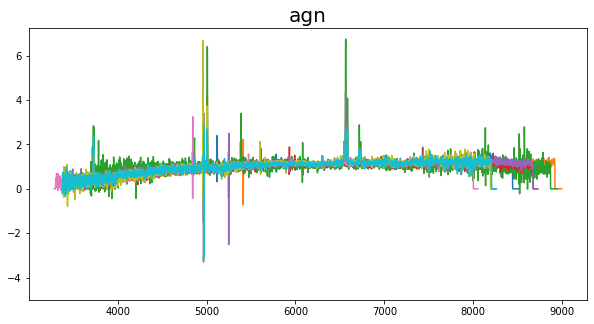

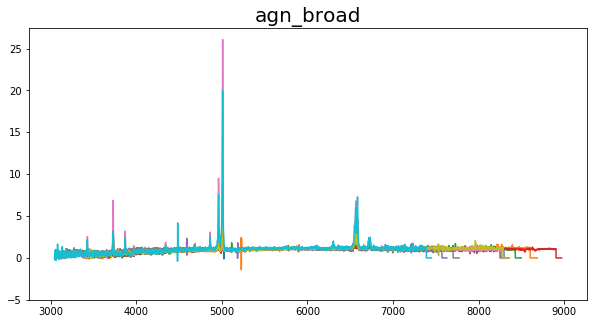

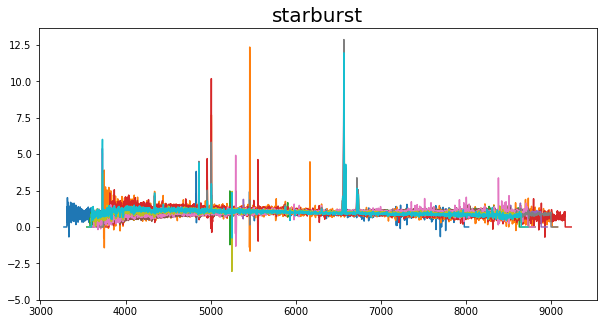

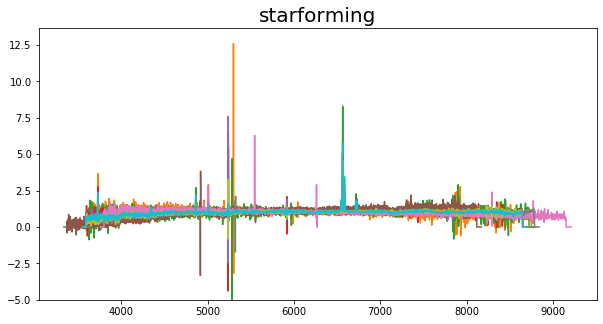

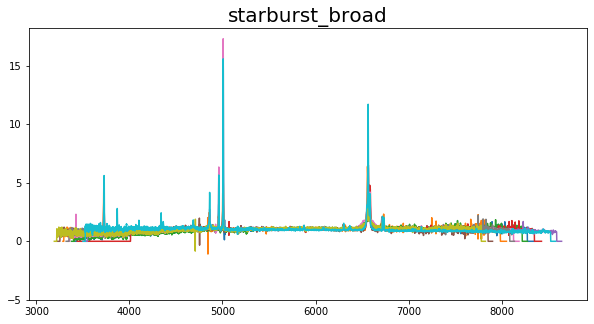

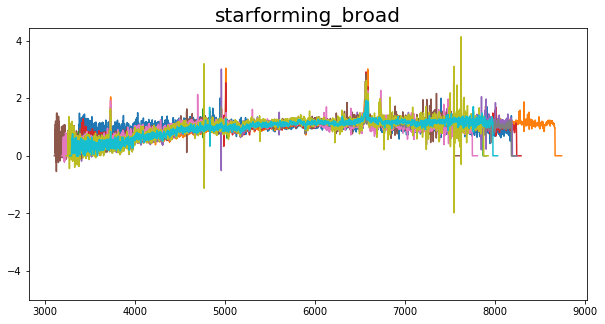

In [11]:
for subpop, lbl in zip([agn, agn_broad, starburst, starforming, starburst_broad, starforming_broad], ['agn', 'agn_broad', 'starburst', 'starforming', 'starburst_broad', 'starforming_broad']): 
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    for i in np.arange(len(tspec))[subpop][:10]: 
        sub.plot(10**specs['wave']/(1+specs['z'][i]), specs['spectra'][i]/np.median(specs['spectra'][i]))
    sub.set_ylim(-5, None)
    sub.set_title(lbl, fontsize=20)
    
    fout = os.path.join(dat_dir, 'sdss_spectra.%s.npz' % lbl)
    print("saving to %s" % fout)
    np.savez(fout,
             wave=specs['wave'],
             spectra=specs['spectra'][subpop][:100],
             mask=specs['mask'][subpop][:100],
             ivar=specs['ivar'][subpop][:100],
             z=specs['z'][subpop][:100], 
             zerr=specs['zerr'][subpop][:100],
             plate=specs['plate'][subpop][:100],
             mjd=specs['mjd'][subpop][:100],
             fiber=specs['fiber'][subpop][:100])